In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Load the dataset

In [2]:
df = pd.read_csv("../../Data/TimeSeriesData/Alcohol_Sales.csv",index_col=0,parse_dates=True)
print(f"df shape : {df.shape}")
df.dropna(inplace=True)
len(df)

df shape : (325, 1)


325

In [3]:
df.head

<bound method NDFrame.head of             S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
...                    ...
2018-09-01           12396
2018-10-01           13914
2018-11-01           14174
2018-12-01           15504
2019-01-01           10718

[325 rows x 1 columns]>

In [4]:
df.tail

<bound method NDFrame.tail of             S4248SM144NCEN
DATE                      
1992-01-01            3459
1992-02-01            3458
1992-03-01            4002
1992-04-01            4564
1992-05-01            4221
...                    ...
2018-09-01           12396
2018-10-01           13914
2018-11-01           14174
2018-12-01           15504
2019-01-01           10718

[325 rows x 1 columns]>

## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

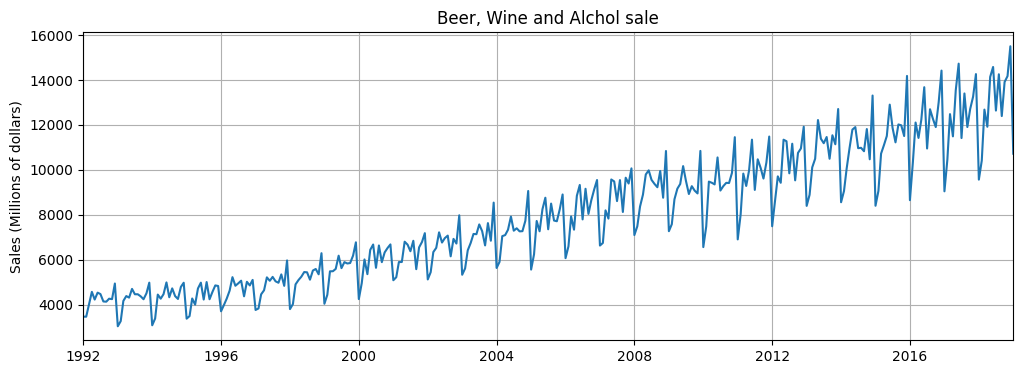

In [5]:
plt.figure(figsize=(12,4))
plt.title("Beer, Wine and Alchol sale")
plt.ylabel("Sales (Millions of dollars)")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [6]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

#Define test size
test_size = 12

#Create the train ans test sets
train_set = y[:-test_size]
test_set = y[-test_size:]
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scalar = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training set
train_form = scalar.fit_transform(train_set.reshape(-1, 1))
print(train_form.max())
print(train_form.min())
print(train_form.mean())
# train_form

1.0
-1.0
-0.2041940178388313


## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [12]:
# Convert train_norm from an array to a tensor
train_form = torch.FloatTensor(train_form).view(-1)

#Define window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_form,window_size)
len(train_data) # this should equal 325-12-12

301

In [22]:
train_form.shape

torch.Size([313])

In [13]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

### Define the model

In [16]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add the LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size)

        #Add a fully connected layer
        self.linear = nn.Linear(hidden_size, output_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       (torch.zeros(1,1,self.hidden_size)))
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1] # We will get the last value


## Instantiate the model, define loss and optimization functions

In [17]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f"{item:>6}")
    print(f"_______\n {sum(params):>6}")

count_parameters(model)

   400
 40000
   400
   400
   100
     1
_______
  41301


## Train the model

In [20]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        #Reset the parameters ans hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    # Print training result
    print(f"Epochs {epoch+1:2} Loss {loss.item():10.8f}")

print(f"Duration : {time.time() - start_time:.0f} seconds")

Epochs  1 Loss 0.25310197
Epochs  2 Loss 0.37531984
Epochs  3 Loss 0.39027184
Epochs  4 Loss 0.34934711
Epochs  5 Loss 0.33085644
Epochs  6 Loss 0.33229989
Epochs  7 Loss 0.32670355
Epochs  8 Loss 0.32074130
Epochs  9 Loss 0.30653527
Epochs 10 Loss 0.29518017
Epochs 11 Loss 0.26934293
Epochs 12 Loss 0.25998455
Epochs 13 Loss 0.24665904
Epochs 14 Loss 0.22404331
Epochs 15 Loss 0.18602531
Epochs 16 Loss 0.18561123
Epochs 17 Loss 0.17208962
Epochs 18 Loss 0.25157180
Epochs 19 Loss 0.22556610
Epochs 20 Loss 0.17435542
Epochs 21 Loss 0.20223172
Epochs 22 Loss 0.20853928
Epochs 23 Loss 0.16687755
Epochs 24 Loss 0.17535597
Epochs 25 Loss 0.12015918
Epochs 26 Loss 0.08407965
Epochs 27 Loss 0.02809244
Epochs 28 Loss 0.00518546
Epochs 29 Loss 0.04879475
Epochs 30 Loss 0.00195645
Epochs 31 Loss 0.00053442
Epochs 32 Loss 0.00606895
Epochs 33 Loss 0.00656311
Epochs 34 Loss 0.02569892
Epochs 35 Loss 0.04110435
Epochs 36 Loss 0.01488878
Epochs 37 Loss 0.00585471
Epochs 38 Loss 0.00376957
Epochs 39 Lo

## Run predictions and compare to known test set

In [23]:
train_form.shape

torch.Size([313])

In [28]:
future = 12

#Add the last value of the trainig values to the list of predicition
preds = train_form[-window_size:].tolist()
print(len(preds))

#Set the model for the evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

print(len(preds))

12
24


In [29]:
#Display the predicted values
preds[window_size:]   #Equivalent to preds[-future:]

[0.28008630871772766,
 0.6459155082702637,
 0.44621729850769043,
 0.8344260454177856,
 1.049583077430725,
 0.35027015209198,
 0.8065066933631897,
 0.5436753034591675,
 0.6495208740234375,
 0.8327378630638123,
 0.8436179161071777,
 0.17971603572368622]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [30]:
true_predictions = scalar.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_predictions

array([[10518.86486284],
       [12658.78276563],
       [11490.64808762],
       [13761.47515267],
       [15020.03621143],
       [10929.40525466],
       [13598.16090283],
       [12060.72868758],
       [12679.8723526 ],
       [13751.60012999],
       [13815.24300027],
       [ 9931.74895097]])

In [31]:
df["S4248SM144NCEN"][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [32]:
# Remember the stop date has to be later then the last predicted value
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

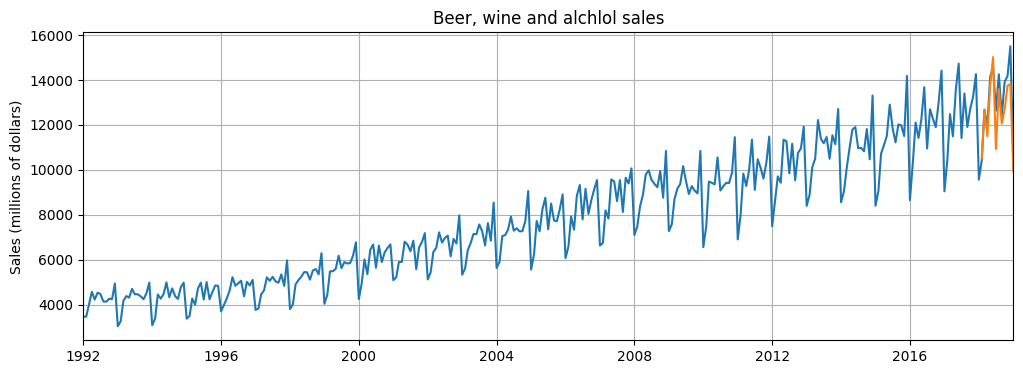

In [37]:
plt.figure(figsize=(12,4))
plt.title("Beer, wine and alchlol sales")
plt.ylabel("Sales (millions of dollars)")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df["S4248SM144NCEN"])
plt.plot(x, true_predictions)
plt.show()

[]

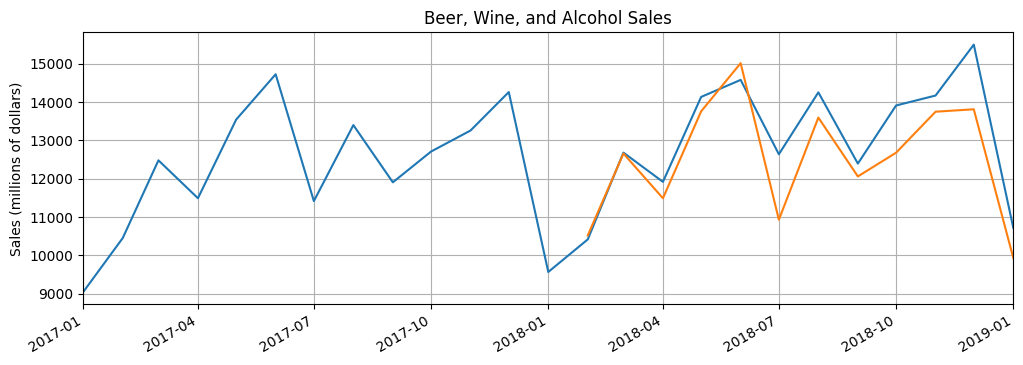

In [38]:
#Plot the endo of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

#Select the end date of the graph by doing the slice notation
plt.plot(df["S4248SM144NCEN"] ['2017-01-01':])
plt.plot(x, true_predictions)
plt.plot()


# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [43]:
print(y.shape)
print(y.reshape(-1, 1).shape)

(325,)
(325, 1)


In [45]:
epochs = 100

#Set the model back to training mode
model.train()

# Feature scale the entire dataset
y_norm = scalar.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

import time
start_time = time.time()

for epoch in range(epochs):

    # Train on full set of sequence
    for seq, y_train in all_data:

        #Reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    # Print training results
    print(f"Epochs : {epoch+1:2}  Loss : {loss.item():10.8f}")

print(f"\n Duration : {time.time() - start_time:0f} seconds")


Epochs :  1  Loss : 0.01771112
Epochs :  2  Loss : 0.01805015
Epochs :  3  Loss : 0.01555644
Epochs :  4  Loss : 0.01582721
Epochs :  5  Loss : 0.01747091
Epochs :  6  Loss : 0.01881390
Epochs :  7  Loss : 0.01928473
Epochs :  8  Loss : 0.01841086
Epochs :  9  Loss : 0.01757328
Epochs : 10  Loss : 0.01416196
Epochs : 11  Loss : 0.01424043
Epochs : 12  Loss : 0.01619883
Epochs : 13  Loss : 0.01622749
Epochs : 14  Loss : 0.01364102
Epochs : 15  Loss : 0.01418076
Epochs : 16  Loss : 0.01422427
Epochs : 17  Loss : 0.01496677
Epochs : 18  Loss : 0.01531463
Epochs : 19  Loss : 0.01227677
Epochs : 20  Loss : 0.01100820
Epochs : 21  Loss : 0.01069531
Epochs : 22  Loss : 0.01047997
Epochs : 23  Loss : 0.01410335
Epochs : 24  Loss : 0.01108762
Epochs : 25  Loss : 0.00832473
Epochs : 26  Loss : 0.00767038
Epochs : 27  Loss : 0.00807626
Epochs : 28  Loss : 0.00845512
Epochs : 29  Loss : 0.00751690
Epochs : 30  Loss : 0.00658051
Epochs : 31  Loss : 0.00490108
Epochs : 32  Loss : 0.00180164
Epochs :

## Predict future values, plot the result

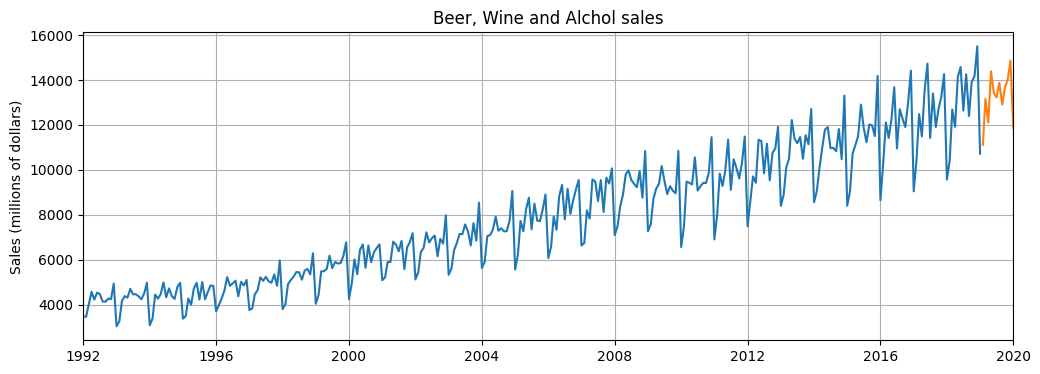

In [46]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

#Inverse normalize the presiction set
true_predictions = scalar.inverse_transform(np.array(preds).reshape(-1, 1))


# PLOT THE RESULT
# Set a date range for the predicted data
# Remember the stop date has to be later than the last predicted value
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[M]')

plt.figure(figsize=(12,4))
plt.title("Beer, Wine and Alchol sales")
plt.ylabel("Sales (millions of dollars)")
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

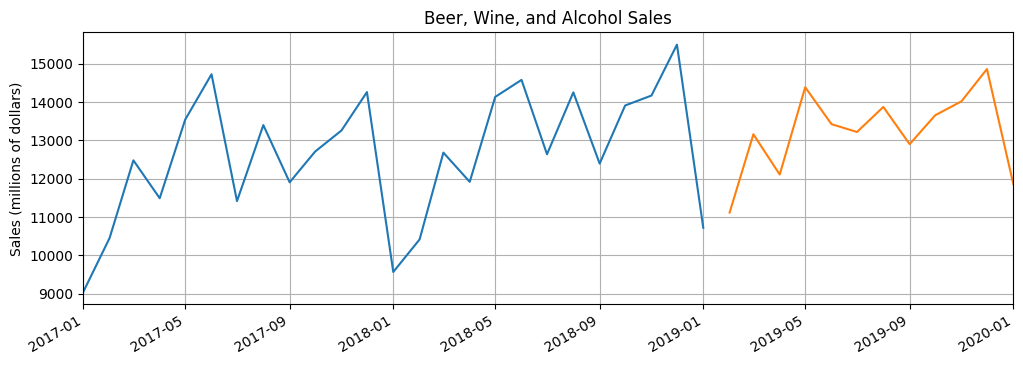

In [47]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()